In [1]:
#train.py

import cv2
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from model import AlexNet
import os
import json
import time


#device : GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ImportError: DLL load failed while importing cv2: 找不到指定的模块。

In [2]:
#数据转换
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [3]:
# 获取图像数据集的路径
image_path = os.path.abspath(os.getcwd())+ "\\flower_data"    # flower data_set path
# data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  		# get data root path 返回上上层目录
# image_path = data_root + "/flower_data/"  				 		# flower data_set path
# print(image_path)


# 导入训练集并进行预处理
train_dataset = datasets.ImageFolder(root=image_path + "/train",		
                                     transform=data_transform["train"])
train_num = len(train_dataset)

# 按batch_size分批次加载训练集
train_loader = torch.utils.data.DataLoader(train_dataset,	# 导入的训练集
                                           batch_size=16, 	# 每批训练的样本数
                                           shuffle=True,	# 是否打乱训练集
                                           num_workers=0)	# 使用线程数，在windows下设置为0

In [11]:
# print(image_path)
# print(train_dataset)
# print(train_num)
# print(len(train_dataset[0][0][0][0]))
# print(len(train_dataset[0][0][0]))
# print(len(train_dataset[0][0]))
# print(len(train_dataset[0]))
# print(len(train_dataset))
# print(train_dataset[10][1])
# print(len(train_loader))

C:\Users\air10\MCM&ICM\flower_data


In [5]:
# 导入验证集并进行预处理
validate_dataset = datasets.ImageFolder(root=image_path + "/val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)

# 加载验证集
validate_loader = torch.utils.data.DataLoader(validate_dataset,	# 导入的验证集
                                              batch_size=16, 
                                              shuffle=True,
                                              num_workers=0)

In [6]:
# 字典，类别：索引 {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
classes_list = train_dataset.class_to_idx
# 将 classes_list 中的 key 和 val 调换位置
cla_dict = dict((val, key) for key, val in classes_list.items())

# 将 cla_dict 写入 json 文件中
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

In [10]:
net = AlexNet(num_classes=5, init_weights=True)  	  # 实例化网络（输出类型为5，初始化权重）
net.to(device)									 	  # 分配网络到指定的设备（GPU/CPU）训练
loss_function = nn.CrossEntropyLoss()			 	  # 交叉熵损失
optimizer = optim.Adam(net.parameters(), lr=0.0002)	  # 优化器（训练参数，学习率）

save_path = './AlexNet.pth'
best_acc = 0.0

for epoch in range(10):
    ########################################## train ###############################################
    net.train()     					# 训练过程中开启 Dropout
    running_loss = 0.0					# 每个 epoch 都会对 running_loss  清零
    time_start = time.perf_counter()	# 对训练一个 epoch 计时
    
    for step, data in enumerate(train_loader, start=0):  # 遍历训练集，step从0开始计算
        images, labels = data   # 获取训练集的图像和标签
        optimizer.zero_grad()	# 清除历史梯度
        
        outputs = net(images.to(device))				 # 正向传播
        loss = loss_function(outputs, labels.to(device)) # 计算损失
#         outputs = net(images.to("cuda"))				 
#         loss = loss_function(outputs, labels.to("cuda"))
        loss.backward()								     # 反向传播
        optimizer.step()								 # 优化器更新参数
        running_loss += loss.item()
        
        # 打印训练进度（使训练过程可视化）
        rate = (step + 1) / len(train_loader)           # 当前进度 = 当前step / 训练一轮epoch所需总step
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
    print('%f s' % (time.perf_counter()-time_start))

    ########################################### validate ###########################################
    net.eval()    # 验证过程中关闭 Dropout
    acc = 0.0  
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
#             outputs = net(val_images.to("cuda"))
            predict_y = torch.max(outputs, dim=1)[1]  # 以output中值最大位置对应的索引（标签）作为预测输出
            acc += (predict_y == val_labels.to(device)).sum().item() 
#             acc += (predict_y == val_labels.to("cuda")).sum().item() 
        val_accurate = acc / val_num
        
        # 保存准确率最高的那次网络参数
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
            
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f \n' %
              (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')

train loss: 100%[**************************************************->]1.715
15.729029 s
[epoch 1] train_loss: 1.358  test_accuracy: 0.459 

train loss: 100%[**************************************************->]1.311
15.585108 s
[epoch 2] train_loss: 1.203  test_accuracy: 0.514 

train loss: 100%[**************************************************->]0.557
15.328188 s
[epoch 3] train_loss: 1.105  test_accuracy: 0.585 

train loss: 100%[**************************************************->]0.888
15.287888 s
[epoch 4] train_loss: 1.055  test_accuracy: 0.654 

train loss: 100%[**************************************************->]1.304
15.282446 s
[epoch 5] train_loss: 0.981  test_accuracy: 0.632 

train loss: 100%[**************************************************->]0.659
15.359794 s
[epoch 6] train_loss: 0.946  test_accuracy: 0.690 

train loss: 100%[**************************************************->]0.843
15.433735 s
[epoch 7] train_loss: 0.908  test_accuracy: 0.692 

train loss: 100%[***

In [12]:
# print(len(data[0][0][0][0]))
# print(len(data[0][0][0]))
# print(len(data[0][0]))
# print(len(data[0]))
# print(len(data))
# print(data)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([0.9335, 0.0165, 0.0094, 0.0280, 0.0127])
0
daisy 0.9335361123085022


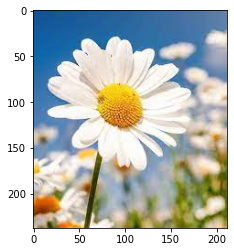

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([0.1947, 0.7023, 0.0421, 0.0207, 0.0402])
1
dandelion 0.7023082375526428


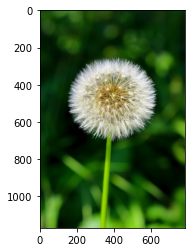

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([1.7261e-03, 2.4519e-04, 7.1349e-01, 1.9888e-04, 2.8434e-01])
2
roses 0.7134944200515747


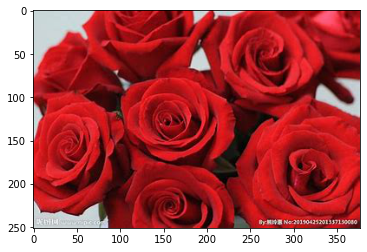

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([3.2046e-08, 2.0009e-03, 1.6693e-07, 9.9793e-01, 6.6028e-05])
3
sunflowers 0.9979329109191895


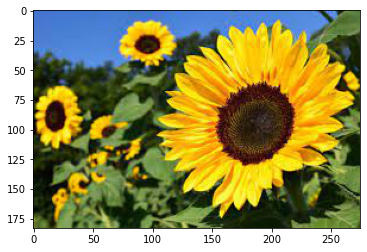

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([0.1051, 0.0931, 0.3269, 0.1073, 0.3676])
4
tulips 0.3675534129142761


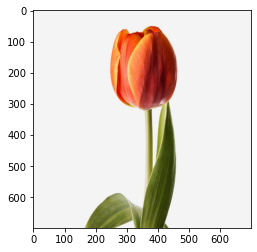

In [13]:
#testing

src_dir = image_path+"\\test"
for file in os.listdir(os.path.abspath(src_dir)):
    # 预处理
    data_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    #load image
    img = Image.open(os.path.join(src_dir,file))
    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    print(img.shape)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    try:
        json_file = open('./class_indices.json', 'r')
        class_indict = json.load(json_file)
    except Exception as e:
        print(e)
        exit(-1)

    # create model
    model = AlexNet(num_classes=5)
    # load model weights
    model_weight_path = "./AlexNet.pth"
    model.load_state_dict(torch.load(model_weight_path))

    # 关闭 Dropout
    model.eval()
    with torch.no_grad():
        # predict class
        print(img.shape)
        output = torch.squeeze(model(img))     # 将输出压缩，即压缩掉 batch 这个维度
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()
    print(predict)
    print(predict_cla)
    print(class_indict[str(predict_cla)], predict[predict_cla].item())
    plt.show()